In [35]:
from evaluation import silhouette_score, davies_bouldin_index, calinski_harabasz_index, wcss, adjusted_rand_index, normalized_mutual_info, purity_score, confusion_matrix

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
# 569 samples
# 30  features
data = pd.read_csv('data.csv')

## droping nan
data = data.drop(columns=["id", "Unnamed: 32"])


In [38]:
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [39]:
#split data
X = data.sample(frac=0.7,random_state = 42)
labels_train = X['diagnosis'].map({'M': 0, 'B': 1}).to_numpy()


rest_of_data = data.drop(X.index)
X = X.drop(columns=["diagnosis"])

X_val = rest_of_data.sample(frac=0.5,random_state = 42)
labels_val = X_val['diagnosis'].map({'M': 0, 'B': 1}).to_numpy()


X_test = rest_of_data.drop(X_val.index)
labels_test = X_test['diagnosis'].map({'M': 0, 'B': 1}).to_numpy()

X_val = X_val.drop(columns=["diagnosis"])
X_test = X_test.drop(columns=["diagnosis"])


In [40]:
def normalize(X):
    mean = np.mean(X, axis=0)               # axis=0 --> works col. by col.
    std = np.std(X, axis=0)

    std[std == 0] = 1.0  

    return (X - mean) / std                 #for each row in x , we subtract mean of each feaure and / by std


In [41]:
def calculate_euclidean(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


In [42]:
def get_intial_centroids_random(X, k):
    n = X.shape[0]
    indices = np.random.choice(n, k, replace=False)
    return X[indices]


def get_intial_centroids_kmeansPP(X, k):
    n = X.shape[0]
    centroids = []
    chosen_indices = set()

    # first centroid
    idx = np.random.randint(n)
    centroids.append(X[idx])
    chosen_indices.add(idx)

    for _ in range(1, k):

        distances = []
        
        for x in X:
            min_dist = np.inf
            for c in centroids:
                dist = np.sum((x - c) ** 2)
                if dist < min_dist:
                    min_dist = dist
            distances.append(min_dist)  

        distances = np.array(distances)

        # choose new centroids with a prob. propetional to distnace
        # prob. to choose a certain point as centroid inc. as dist. bet. it and other centroids inc.
        probs = distances / np.sum(distances)        # array  of size n with each prob. of choosing this point as next center

        # sample until we get a new index
        while True:
            idx = np.random.choice(n, p=probs)
            if idx not in chosen_indices:
                break

        centroids.append(X[idx])
        chosen_indices.add(idx)

    return np.array(centroids)










In [43]:
def assign_clusters(X, centroids):
    no_of_points = X.shape[0]
    labels = np.zeros(no_of_points, dtype=int) #size = no. of poits

    #calc. min. dist. for each point
    for i in range(no_of_points):
        distances = []
        for c in centroids:
            distances.append(calculate_euclidean(X[i], c))

        # will assign point to cluster with min dist.
        labels[i] = np.argmin(distances)        #assigning indices
    return labels

def update_centroids(X, labels, k):
    centroids = np.zeros((k, X.shape[1]))

    for cluster in range(k):
        points = X[labels == cluster]

        # avoid empty cluster
        if len(points) > 0:
            centroids[cluster] = np.mean(points, axis=0)

    return centroids

def compute_inertia(X, labels, centroids):
    inertia = 0.0
    for i in range(len(X)):
        inertia += np.sum((X[i] - centroids[labels[i]]) ** 2)
    return inertia


In [44]:
def kmeans(X, k, max_iters, tolerance,centroids):

    inertia_history = []

    for i in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)

        inertia = compute_inertia(X, labels, new_centroids)
        inertia_history.append(inertia)

        # convergence check
        if i != 0:
            if (inertia_history[i-1] - inertia_history[i]) < tolerance:
                break

        centroids = new_centroids

    return labels,inertia_history


In [45]:
X = X.to_numpy()
X = normalize(X)
X_val = X_val.to_numpy()
X_val = normalize(X_val)
X_test = X_test.to_numpy()
X_test = normalize(X_test)


In [46]:
# type: ignore

#try out diff tolerances
k = 2
tolerances = [ 1e-4,1e-3,1e-2 ]
max_iterations = [20,50,100]
centroids = get_intial_centroids_random(X_val,k)
correctness = []
for tol in tolerances:
    labels_rand,_ = kmeans(X_val,k,100,tol,centroids)
    score = adjusted_rand_index(labels_val,labels_rand)
    correctness.append(score)
index_t = np.argmax(correctness)   
print(f"best tolerance value = {tolerances[index_t]}") 


correctness = []
for iter in max_iterations:
    labels_rand,_ = kmeans(X_val,k,iter,1e-4,centroids)
    score = adjusted_rand_index(labels_val,labels_rand)
    correctness.append(score)
index_it = np.argmax(correctness)   
print(f"best iterations value = {max_iterations[index_it]}") 



	


best tolerance value = 0.0001
best iterations value = 20


In [47]:
# type: ignore

# compare between kmeans++ and random intialization using best tol,iterations
centroids = get_intial_centroids_random(X_val,k)
labels_rand,_ = kmeans(X_val,k,max_iterations[index_it],tolerances[index_t],centroids)
print(f"ARI score for random centroids {adjusted_rand_index(labels_val,labels_rand)}")
centroids_PP = get_intial_centroids_kmeansPP(X_val,k)
labels_PP,_ = kmeans(X_val,k,max_iterations[index_it],tolerances[index_t],centroids_PP)
print(f"ARI score for kmeans++ centroids {adjusted_rand_index(labels_val,labels_PP)}")

ARI score for random centroids 0.6207622350954781
ARI score for kmeans++ centroids 0.6207622350954781


In [48]:
#type: ignore

# Expirment 1 Kmeans on original data

k_values = range(2, 11)

inertias = []
silhouettes = []
gaps = []

B = 10  # number of reference datasets for gap statistic

print("k | Inertia     | Silhouette | Gap")
print("--|-------------|------------|------")

for k in k_values:
    labels, inertia_history = kmeans(X_val, k,100,1e-4,centroids_PP)
    inertia_k = float(inertia_history[-1])
    inertias.append(inertia_k)

    sil_k = float(silhouette_score(X_val, labels))
    silhouettes.append(sil_k)


    log_w_random = []

    for _ in range(B):
        X_rand = np.random.uniform(
            low=np.min(X_val, axis=0),
            high=np.max(X_val, axis=0),
            size=X_val.shape
        )

        _, inertia_hist_rand = kmeans(X_rand, k, 100, 1e-4,centroids_PP)
        log_w_random.append(np.log(float(inertia_hist_rand[-1])))

    gap_k = float(np.mean(log_w_random) - np.log(inertia_k))
    gaps.append(gap_k)

    print(f"{k:>1} | {inertia_k:11.2f} | {sil_k:10.4f} | {gap_k:6.4f}")
    convergence_speed = len(inertia_history) - 1
    print(f"algorithm converged in {convergence_speed} iterations")


k | Inertia     | Silhouette | Gap
--|-------------|------------|------
2 |     1725.91 |     0.3478 | 1.2714
algorithm converged in 4 iterations
3 |     1508.69 |     0.2154 | 1.3867
algorithm converged in 5 iterations
4 |     1317.31 |     0.2155 | 1.5276
algorithm converged in 11 iterations
5 |     1217.87 |     0.1828 | 1.5778
algorithm converged in 16 iterations
6 |     1100.02 |     0.2130 | 1.6907
algorithm converged in 15 iterations
7 |     1048.26 |     0.2220 | 1.7530
algorithm converged in 11 iterations
8 |     1029.48 |     0.1971 | 1.7658
algorithm converged in 10 iterations
9 |     1016.48 |     0.1857 | 1.7823
algorithm converged in 11 iterations
10 |     1016.48 |     0.1857 | 1.7941
algorithm converged in 11 iterations


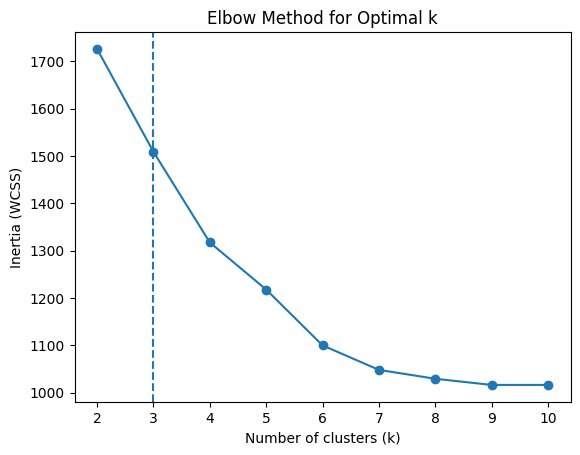

In [49]:


optimal_k = 3  # change if your chosen k is different

plt.figure()
plt.plot(k_values, inertias, marker='o')
plt.axvline(optimal_k, linestyle='--')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal k")
plt.show()


[1 1 0 2 1 0 1 0 0 1 1 1 1 2 2 0 2 1 1 2 2 2 1 2 2 1 0 1 0 0 2 2 2 1 1 1 2
 1 2 1 0 1 1 1 0 1 2 2 2 0 0 2 1 0 1 0 1 1 1 0 1 2 1 0 2 2 2 1 1 0 2 0 0 1
 0 0 1 1 2 1 2 2 2 0 0 0]


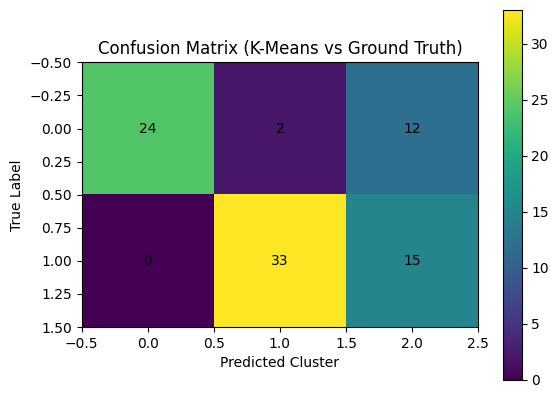

In [50]:
#type: ignore
labels, _ = kmeans(X_val, optimal_k ,max_iterations[index_it],tolerances[index_t],centroids_PP)
cm = confusion_matrix(labels_val, labels)
print(labels)
plt.figure()
plt.imshow(cm)
plt.colorbar()
plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.title("Confusion Matrix (K-Means vs Ground Truth)")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()


In [ ]:
from PCA import PCA
import seaborn as sns

def run_pca_kmeans_experiment(X_input, y_true, pca_components_list, k_search_range):
    results = []
    best_labels_per_dim = {} # To store labels for the best k at each dimension

    for n_comp in pca_components_list:
        
        pca = PCA(n_components=n_comp)
        X_pca = pca.compute_pca(X_input)
        
        # Compute MSE
        X_rec = pca.reconstruct(X_pca)
        mse = pca.reconstruction_error(X_input, X_rec)
        
        # Track best K for THIS dimension
        best_sil_dim = -1
        best_stats_dim = None
        best_labels_dim = None

        # Search for Best k
        for k in k_search_range:
            centroids_init = get_intial_centroids_kmeansPP(X_pca, k)
            
            labels, inertia_hist = kmeans(X_pca, k, 100, 1e-4, centroids_init)
            
                
            # Metrics
            sil = silhouette_score(X_pca, labels)
            db = davies_bouldin_index(X_pca, labels)       
            ch = calinski_harabasz_index(X_pca, labels)    
            ari = adjusted_rand_index(y_true, labels)
            purity = purity_score(y_true, labels)
            final_inertia = inertia_hist[-1] if inertia_hist else 0

            # Selection Logic: Maximize Silhouette
            if sil > best_sil_dim:
                best_sil_dim = sil
                best_labels_dim = labels
                best_stats_dim = {
                    'k': k,
                    'Silhouette': sil,
                    'Davies_Bouldin': db,       
                    'Calinski_Harabasz': ch,    
                    'ARI': ari,
                    'Purity': purity,
                    'Inertia': final_inertia
                }

        if best_stats_dim:
            results.append({
                'n_components': n_comp,
                'MSE': mse,
                **best_stats_dim # Unpacks k, Sil, ARI, Purity...
            })
            best_labels_per_dim[n_comp] = best_labels_dim
            
            print(f" -> PCA={n_comp}: MSE={mse:.4f} | Best k={best_stats_dim['k']} | Sil={best_sil_dim:.3f}")

    return pd.DataFrame(results), best_labels_per_dim

pca_comps = [2, 5, 10, 15, 20] 
k_range = range(2, 8) 

df_kmeans_pca, kmeans_best_labels = run_pca_kmeans_experiment(X_val, labels_val, pca_comps, k_range)

display(df_kmeans_pca)

Starting K-Means + PCA Experiment...
 -> PCA=2: MSE=0.3711 | Best k=3 | Sil=0.528
 -> PCA=5: MSE=0.1490 | Best k=4 | Sil=0.419
 -> PCA=10: MSE=0.0335 | Best k=3 | Sil=0.367
 -> PCA=15: MSE=0.0085 | Best k=3 | Sil=0.358
 -> PCA=20: MSE=0.0024 | Best k=3 | Sil=0.350


,n_components,MSE,k,Silhouette,ARI,Purity,Inertia
0,2,0.371055,3,0.527726,0.476440,0.860465,513.753718
1,5,0.148988,4,0.418569,0.450777,0.872093,956.787395
2,10,0.033458,3,0.366735,0.460067,0.872093,1345.122287
3,15,0.008457,3,0.358153,0.460067,0.872093,1408.840014
4,20,0.002351,3,0.350376,0.479229,0.883721,1435.872011


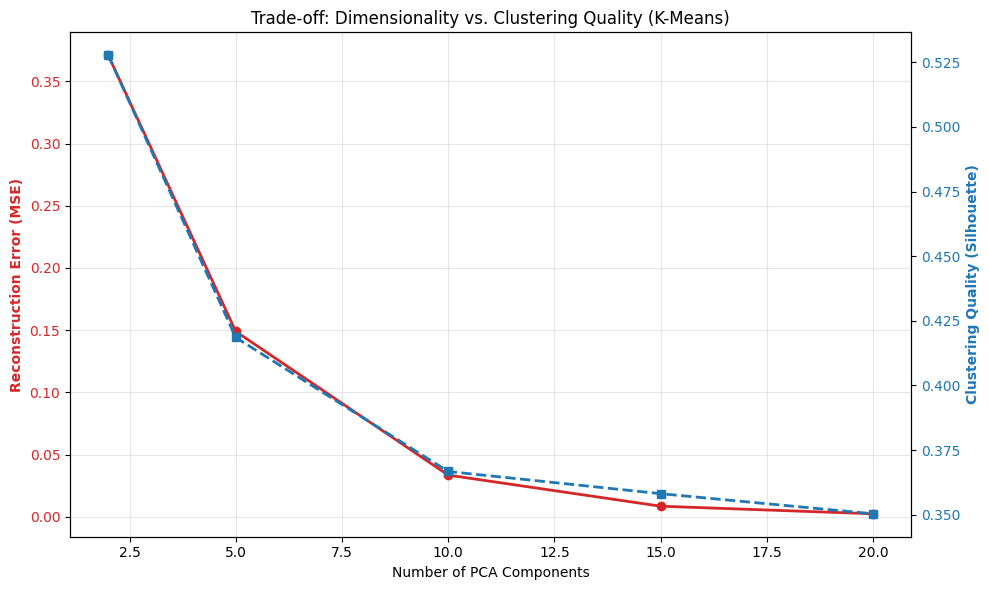

In [ ]:
def plot_kmeans_tradeoff(df):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot 1: MSE 
    color = 'tab:red'
    ax1.set_xlabel('Number of PCA Components')
    ax1.set_ylabel('Reconstruction Error (MSE)', color=color, fontweight='bold')
    ax1.plot(df['n_components'], df['MSE'], color=color, marker='o', linestyle='-', linewidth=2, label='MSE')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Silhouette 
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Clustering Quality (Silhouette)', color=color, fontweight='bold')
    ax2.plot(df['n_components'], df['Silhouette'], color=color, marker='s', linestyle='--', linewidth=2, label='Silhouette')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Trade-off: Dimensionality vs. Clustering Quality (K-Means)')
    plt.tight_layout()
    plt.show()

plot_kmeans_tradeoff(df_kmeans_pca)

Visualizing Winner: PCA=2, k=3


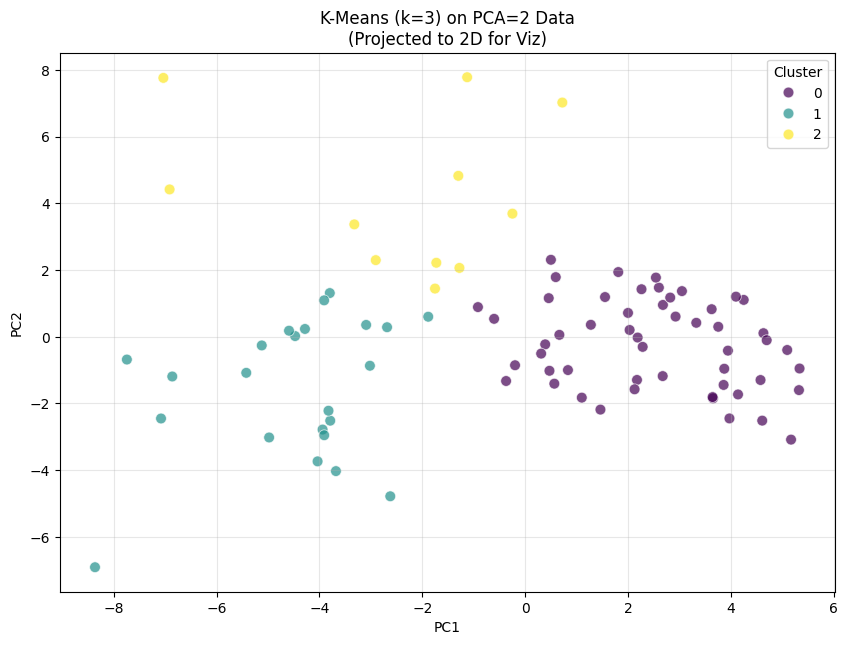

In [ ]:
best_row = df_kmeans_pca.loc[df_kmeans_pca['Silhouette'].idxmax()]
best_n = int(best_row['n_components'])
best_k = int(best_row['k'])
best_labels = kmeans_best_labels[best_n]

print(f"Visualizing Winner: PCA={best_n}, k={best_k}")

# 2. Project to 2D for plotting 
pca_viz = PCA(n_components=2)
X_proj_2d = pca_viz.compute_pca(X_val)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_proj_2d[:, 0], 
    y=X_proj_2d[:, 1], 
    hue=best_labels, 
    palette='viridis', 
    s=60, alpha=0.7
)
plt.title(f"K-Means (k={best_k}) on PCA={best_n} Data\n(Projected to 2D for Viz)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

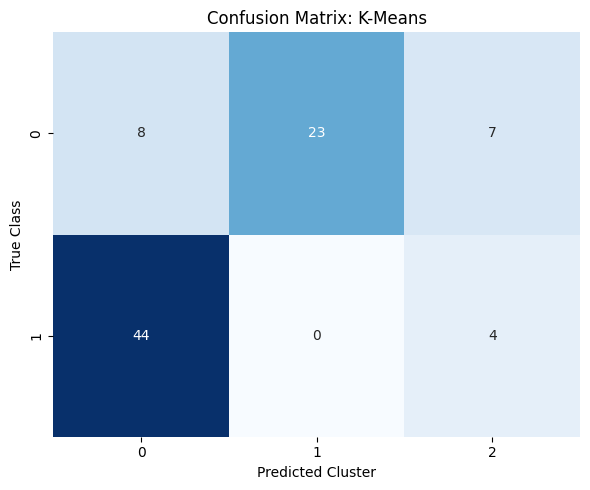

In [56]:
best_row_km = df_kmeans_pca.loc[df_kmeans_pca['Silhouette'].idxmax()]
best_n_km = int(best_row_km['n_components'])
best_k_km = int(best_row_km['k'])

best_labels_km = kmeans_best_labels[best_n_km]

cm = confusion_matrix(labels_val, best_labels_km)
    
# 2. Plot Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Cluster")
plt.ylabel("True Class")
plt.title(f"Confusion Matrix: K-Means")
plt.tight_layout()
plt.show()